In [89]:
import pandas as pd
import numpy as np
import torch
import re
import tqdm
import seaborn as sns

from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.data import Iterator, BucketIterator

from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

## Dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
dataset=pd.read_csv('data/final_data.csv')


In [4]:
dataset.head()

,Unnamed: 0,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,0,3,0,0,1,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,3,0,1,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,2,3,0,1,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,3,0,1,0,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,4,6,0,1,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:

def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("RT", "",tweet) # Removing 'RT' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    tweet = word_tokenize(tweet)
    return tweet

In [6]:
TEXT = Field(sequential=True, tokenize=clean_tweet, lower=True,batch_first=True)
LABEL = Field(sequential=False, use_vocab=False)


In [7]:
dataset_datafields = [("",None),("id",None),("count", None),
                      ("hate_speech", LABEL),("offensive_language", LABEL),
                      ("neither", LABEL),("label", None),("tweet",TEXT)
                    ]

data = TabularDataset(
        path="data/final_data.csv", # the root directory where the data lies
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=dataset_datafields)
train,test,valid=data.split([0.8,0.1,0.1])

## Building the vocabulary 

In [8]:
TEXT.build_vocab(train)


## Dataloader

In [9]:
train_iter, val_iter = BucketIterator.splits(
        (train, valid), # we pass in the datasets we want the iterator to draw data from
        batch_sizes=(64, 64),
        device=device, # if you want to use the GPU, specify the GPU number here
        sort_key=lambda x: len(x.tweet), # the BucketIterator needs to be told what function it should use to group the data.
        sort_within_batch=False,
        repeat=False # we pass repeat=False because we want to wrap this Iterator layer.
)
test_iter = Iterator(test, batch_size=64, device=device, sort=False, sort_within_batch=False, repeat=False)

In [10]:
class BatchWrapper:
    def __init__(self, dl, x_var, y_vars):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x and y

    
    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            if self.y_vars is not None: # we will concatenate y into a single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            else:
                y = torch.zeros((1))

            yield (x, y)
    
    def __len__(self):
        return len(self.dl)

In [11]:

train_dl = BatchWrapper(train_iter, "tweet", ["hate_speech","offensive_language","neither"])
test_dl = BatchWrapper(test_iter, "tweet", ["hate_speech","offensive_language","neither"])
val_dl = BatchWrapper(val_iter, "tweet", ["hate_speech","offensive_language","neither"])


# MODEL: Self Attention

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F


In [13]:

class SelfAttention(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
        super(SelfAttention, self).__init__()

        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 2 = (pos, neg)
        hidden_sie : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
        
        --------

        """

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.weights = weights

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
        self.dropout = 0.8
        self.bilstm = nn.LSTM(embedding_length, hidden_size, dropout=self.dropout, bidirectional=True)
        # We will use da = 350, r = 30 & penalization_coeff = 1 as per given in the self-attention original ICLR paper
        self.W_s1 = nn.Linear(2*hidden_size, 350)
        self.W_s2 = nn.Linear(350, 30)
        self.fc_layer = nn.Linear(30*2*hidden_size, 2000)
        self.label = nn.Linear(2000, output_size)

    def attention_net(self, lstm_output):

        """
        Now we will use self attention mechanism to produce a matrix embedding of the input sentence in which every row represents an
        encoding of the input sentence but giving an attention to a specific part of the sentence. We will use 30 such embedding of 
        the input sentence and then finally we will concatenate all the 30 sentence embedding vectors and connect it to a fully 
        connected layer of size 2000 which will be connected to the output layer of size 2 returning logits for our two classes i.e., 
        pos & neg.
        Arguments
        ---------
        lstm_output = A tensor containing hidden states corresponding to each time step of the LSTM network.
        ---------
        Returns : Final Attention weight matrix for all the 30 different sentence embedding in which each of 30 embeddings give
                  attention to different parts of the input sentence.
        Tensor size : lstm_output.size() = (batch_size, num_seq, 2*hidden_size)
                      attn_weight_matrix.size() = (batch_size, 30, num_seq)
        """
        attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
        attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
        attn_weight_matrix = torch.softmax(attn_weight_matrix, dim=2)

        return attn_weight_matrix

    def forward(self, input_sentences, batch_size=None):

        """ 
        Parameters
        ----------
        input_sentence: input_sentence of shape = (batch_size, num_sequences)
        batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
        
        Returns
        -------
        Output of the linear layer containing logits for pos & neg class.
        
        """

        input = self.word_embeddings(input_sentences)
        input = input.permute(1, 0, 2)
        if batch_size is None:
            h_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
        else:
            h_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())

        output, (h_n, c_n) = self.bilstm(input, (h_0, c_0))
        output = output.permute(1, 0, 2)

        attn_weight_matrix = self.attention_net(output)
        hidden_matrix = torch.bmm(attn_weight_matrix, output)

        # Let's now concatenate the hidden_matrix and connect it to the fully connected layer.
        fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2]))
        logits = self.label(fc_out)
        # logits.size() = (batch_size, output_size)

        return logits,attn_weight_matrix

In [14]:
batch_size=128
num_classes=3
h_emb=500
emb_size=100
vocab_Size=len(TEXT.vocab)
vectors=TEXT.vocab.vectors
model = SelfAttention(batch_size, num_classes, h_emb, vocab_Size, emb_size, TEXT.vocab.vectors)
model.cuda()


/home/yashaswi.pathak/.local/lib/python3.5/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


SelfAttention(
  (word_embeddings): Embedding(30359, 100)
  (bilstm): LSTM(100, 500, dropout=0.8, bidirectional=True)
  (W_s1): Linear(in_features=1000, out_features=350, bias=True)
  (W_s2): Linear(in_features=350, out_features=30, bias=True)
  (fc_layer): Linear(in_features=30000, out_features=2000, bias=True)
  (label): Linear(in_features=2000, out_features=3, bias=True)
)

## Gradient Clipping

In [15]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)


In [16]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',verbose=True,patience=5)
loss_func = nn.BCEWithLogitsLoss()
epochs=5

In [17]:
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() # turn on training mode
    for x,y in tqdm.tqdm(train_dl):
        text = x
        target = y

        opt.zero_grad()
        prediction,attentin_matrix = model(text,text.size()[0])
        loss = loss_func(prediction, target)
        loss.backward()
        clip_gradient(model, 1e-1)
        opt.step()
        running_loss += loss.data.item() * x.size(0)
        
    epoch_loss = running_loss / len(train)
    
    val_loss = 0.0
    model.eval() # turn on evaluation mode
    for x,y in val_dl:
        preds,attentin_matrix = model(x,x.size()[0])
        loss = loss_func(preds, y)
        val_loss += loss.data.item() * x.size(0)

    val_loss /= len(valid)
    scheduler.step(val_loss)
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, epoch_loss, val_loss))

  1%|          | 3/310 [00:00<00:11, 26.10it/s]

Epoch: 1, Training Loss: 0.2770, Validation Loss: 0.2170


  1%|          | 3/310 [00:00<00:11, 26.20it/s]

Epoch: 2, Training Loss: 0.1876, Validation Loss: 0.1901


  1%|          | 3/310 [00:00<00:11, 26.21it/s]

Epoch: 3, Training Loss: 0.1588, Validation Loss: 0.2028


  1%|          | 3/310 [00:00<00:11, 25.75it/s]

Epoch: 4, Training Loss: 0.1281, Validation Loss: 0.2569


100%|██████████| 310/310 [00:09<00:00, 32.24it/s]


Epoch: 5, Training Loss: 0.0974, Validation Loss: 0.3250


In [40]:
accuracy=0
count=0
predictions=[]
actual=[]
for x,y in test_dl:
    preds,attentin_matrix = model(x,x.size()[0])
    preds = F.softmax(preds,1)
    for idx,p in enumerate(preds):
        curr_pred=np.argmax(np.round(p.detach().tolist()))
        curr_gt=np.argmax(np.round(y[idx].tolist()))
        predictions.append(curr_pred)
        actual.append(curr_gt)
        if np.array_equal(curr_pred,curr_gt):
            accuracy+=1
        count+=1


# Accuracy of model

In [43]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [44]:
f = f1_score( actual,predictions, average='micro')
print("F1 Score: ", f)
p = precision_score(actual, predictions, average='micro')
print("Precision Score: ", p)
r = recall_score(actual, predictions, average='micro')
print("Recall Score: ", r)
a = accuracy_score(actual, predictions)
print("Accuracy Score: ", a)

F1 Score:  0.8850342880193626
Precision Score:  0.8850342880193627
Recall Score:  0.8850342880193627
Accuracy Score:  0.8850342880193627


## Analysis of attention map

- Using the attention matrix to analysze the individual contributions from the words

Class:  Hatespeech


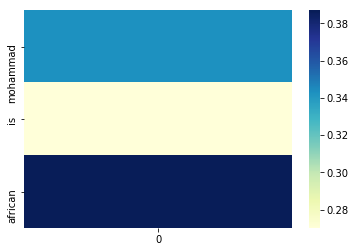

In [119]:
''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
classes={0:'Hatespeech',1:'Offensive',2:'Neither'}
test_sen1 = "Mohammad is African"
test_sen1 = TEXT.preprocess(test_sen1)
sentence=test_sen1
test_sen1 = [[TEXT.vocab.stoi[x] for x in test_sen1]]


test_sen = np.asarray(test_sen1)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen)
test_tensor = test_tensor.cuda()
model.eval()

output,attention_matrix = model(test_tensor, 1)
out = torch.softmax(output, 1)
print("Class: ", classes[torch.argmax(out).item()])

attention=torch.mean(attention_matrix,1)
attention = attention
attended_words=zip(sentence,attention[0])
individual_attention=list(np.zeros(len(sentence)))
individual_labels=list(np.zeros(len(sentence)))
for index,i in enumerate(attended_words):
    individual_labels[index], individual_attention[index] = i[0], i[1].item()

data_frame=pd.DataFrame(individual_attention,index=individual_labels)
sns.heatmap(data_frame,cmap='YlGnBu')

- We can see sentence like "Mohammad is African" is predicted as hatespeech.

Class:  Neither


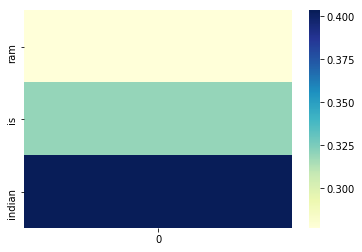

In [118]:
''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
classes={0:'Hatespeech',1:'Offensive',2:'Neither'}
test_sen1 = "Ram is Indian"
test_sen1 = TEXT.preprocess(test_sen1)
sentence=test_sen1
test_sen1 = [[TEXT.vocab.stoi[x] for x in test_sen1]]


test_sen = np.asarray(test_sen1)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen)
test_tensor = test_tensor.cuda()
model.eval()

output,attention_matrix = model(test_tensor, 1)
out = torch.softmax(output, 1)
print("Class: ", classes[torch.argmax(out).item()])

attention=torch.mean(attention_matrix,1)
attention = attention
attended_words=zip(sentence,attention[0])
individual_attention=list(np.zeros(len(sentence)))
individual_labels=list(np.zeros(len(sentence)))
for index,i in enumerate(attended_words):
    individual_labels[index], individual_attention[index] = i[0], i[1].item()

data_frame=pd.DataFrame(individual_attention,index=individual_labels)
sns.heatmap(data_frame,cmap='YlGnBu')

- We can see sentence like "Ram is Indian" is predicted as "Neither". 

- The above to results show the biasness in the model, these can be removed by using named entities ,like "noun phase person" inplace of actual name like "ram" and like wise for person.
- One can also use a pretrained model to predict the score of these bias words from attention map, then take a reciprocal of these score and use these and ground truth for alpha_i in the attention map 